In [1]:
# ======================================================================
# 1. 配置与环境设置 (CONFIG & SETUP)
# ======================================================================
import os
import zipfile
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import cv2
import random
import time
from tqdm import tqdm # 引入tqdm来显示进度条

# --- 超参数配置 ---
class Config:
    # --- 设备配置 ---
    GPU_ID = 3
    DEVICE = None # 将在下面设置
    # --- 数据路径 ---
    DATA_PATH_PREFIX = 'data/Unet/'
    TRAIN_IMG_PATH = os.path.join(DATA_PATH_PREFIX, 'train-volume.tif')
    TRAIN_LBL_PATH = os.path.join(DATA_PATH_PREFIX, 'train-labels.tif')
    TEST_IMG_PATH = os.path.join(DATA_PATH_PREFIX, 'test-volume.tif')
    MODEL_SAVE_PATH = 'best_attention_unet_model.pth'

    # --- 训练参数 ---
    NUM_EPOCHS = 100 # 增加训练轮数，配合早停使用
    BATCH_SIZE = 4
    LEARNING_RATE = 1e-4
    VALIDATION_SPLIT = 0.2 # 使用20%的数据作为验证集
    
    # --- 模型参数 ---
    N_CHANNELS = 1 # 输入通道数 (灰度图)
    N_CLASSES = 2  # 类别数 (背景 + 细胞)
    
    # --- 早停参数 ---
    EARLY_STOPPING_PATIENCE = 10 # 10个epoch验证集性能不提升则停止

# --- 初始化环境 ---
def setup_environment(config):
    """设置GPU设备和随机种子"""
    os.environ["CUDA_VISIBLE_DEVICES"] = str(config.GPU_ID)
    config.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        print(f"Successfully set to use Physical GPU {config.GPU_ID}.")
        print(f"PyTorch sees it as device: {config.DEVICE}")
    else:
        print(f"Using device: {config.DEVICE}")

    # 设置随机种子
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 实例化配置并设置环境
config = Config()
setup_environment(config)

Successfully set to use Physical GPU 3.
PyTorch sees it as device: cuda


In [2]:

# ======================================================================
# 2. 数据加载与增强 (DATA LOADING & AUGMENTATION)
# ======================================================================
def load_multipage_tiff(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found at {path}")
    return np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(path))])

class ISBI_Dataset(Dataset):
    def __init__(self, images, labels, augment=False):
        self.images = images
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def _apply_transforms(self, image, mask):
        """应用数据增强"""
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        # 1. 随机几何变换 (旋转、翻转)
        if random.random() > 0.5:
            angle = random.uniform(-30, 30)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        # 2. 随机仿射变换 (包含缩放和切变)
        if random.random() > 0.5:
            scale = random.uniform(0.8, 1.2)
            shear = random.uniform(-10, 10)
            image = TF.affine(image, angle=0, translate=(0, 0), scale=scale, shear=shear)
            mask = TF.affine(mask, angle=0, translate=(0, 0), scale=scale, shear=shear)
        
        # 3. 颜色抖动 (亮度、对比度)
        if random.random() > 0.5:
            image = TF.adjust_brightness(image, brightness_factor=random.uniform(0.7, 1.3))
            image = TF.adjust_contrast(image, contrast_factor=random.uniform(0.7, 1.3))

        # 4. 转换为Tensor并进行归一化
        image = TF.to_tensor(image) # 自动将[0,255]归一化到[0,1]
        mask = torch.from_numpy(np.array(mask)).long()
        mask[mask == 255] = 1 # 将前景标签从255转为1
        
        return image, mask

    def __getitem__(self, idx):
        image_np = self.images[idx]
        mask_np = self.labels[idx]

        if self.augment:
            return self._apply_transforms(image_np, mask_np)
        else:
            # 对于验证集，只做Tensor转换和归一化
            image = TF.to_tensor(Image.fromarray(image_np))
            mask = torch.from_numpy(mask_np).long()
            mask[mask == 255] = 1
            return image, mask


In [3]:
# ======================================================================
# 3. 模型改进 (IMPROVED MODEL - ATTENTION U-NET)
# ======================================================================
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

# --- 新增：注意力模块 ---
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, use_attention=True):
        super().__init__()
        self.use_attention = use_attention
        # 使用转置卷积进行上采样，它有可学习的参数
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        if self.use_attention:
            self.attn = AttentionBlock(F_g=in_channels // 2, F_l=in_channels // 2, F_int=in_channels // 4)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 尺寸对齐
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = TF.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        
        if self.use_attention:
            x2 = self.attn(g=x1, x=x2)
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

# --- 最终模型：Attention U-Net ---
class AttentionUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(AttentionUNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

In [4]:
# ======================================================================
# 4. 损失函数与评估指标 (LOSS & METRICS)
# ======================================================================
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred_logits, target):
        # 使用softmax将logits转换为概率
        pred_prob = torch.softmax(pred_logits, dim=1)
        # 将target转换为one-hot
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=config.N_CLASSES).permute(0, 3, 1, 2)
        
        # 只计算前景(类别1)的Dice Loss
        pred_fg = pred_prob[:, 1, ...]
        target_fg = target_one_hot[:, 1, ...].float()
        
        intersection = (pred_fg * target_fg).sum()
        union = pred_fg.sum() + target_fg.sum()
        
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score

# --- 组合损失 ---
class CombinedLoss(nn.Module):
    def __init__(self, ce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.ce_weight = ce_weight
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()

    def forward(self, pred_logits, target):
        ce = self.ce_loss(pred_logits, target)
        dice = self.dice_loss(pred_logits, target)
        return self.ce_weight * ce + (1 - self.ce_weight) * dice

def dice_metric_func(pred_logits, target, smooth=1e-6):
    """计算Dice系数指标（用于评估）"""
    pred_class = pred_logits.argmax(dim=1)
    target_one_hot = torch.nn.functional.one_hot(target, num_classes=config.N_CLASSES).permute(0, 3, 1, 2)
    pred_one_hot = torch.nn.functional.one_hot(pred_class, num_classes=config.N_CLASSES).permute(0, 3, 1, 2)
    
    intersection = (pred_one_hot[:, 1] * target_one_hot[:, 1]).sum()
    union = pred_one_hot[:, 1].sum() + target_one_hot[:, 1].sum()
    
    return (2. * intersection + smooth) / (union + smooth)

In [5]:

# ======================================================================
# 5. 训练与验证循环 (TRAINING & VALIDATION)
# ======================================================================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            dice = dice_metric_func(outputs, masks)
            
            total_loss += loss.item()
            total_dice += dice.item()
            
    avg_loss = total_loss / len(loader)
    avg_dice = total_dice / len(loader)
    return avg_loss, avg_dice

Data loaded: 24 training samples, 6 validation samples.

--- Starting Training with Attention U-Net ---


Epoch 1/100 | Train Loss: 0.4303 | Val Loss: 0.4877 | Val Dice: 0.8789
  -> New best model saved with Dice: 0.8789


Epoch 2/100 | Train Loss: 0.3226 | Val Loss: 0.4493 | Val Dice: 0.8789


Epoch 3/100 | Train Loss: 0.2756 | Val Loss: 0.3953 | Val Dice: 0.8789


Epoch 4/100 | Train Loss: 0.2643 | Val Loss: 0.3390 | Val Dice: 0.8780


Epoch 5/100 | Train Loss: 0.2631 | Val Loss: 0.3042 | Val Dice: 0.8817
  -> New best model saved with Dice: 0.8817


Epoch 6/100 | Train Loss: 0.2568 | Val Loss: 0.2794 | Val Dice: 0.8953
  -> New best model saved with Dice: 0.8953


Epoch 7/100 | Train Loss: 0.2256 | Val Loss: 0.2355 | Val Dice: 0.9194
  -> New best model saved with Dice: 0.9194


Epoch 8/100 | Train Loss: 0.2240 | Val Loss: 0.2200 | Val Dice: 0.9290
  -> New best model saved with Dice: 0.9290


Epoch 9/100 | Train Loss: 0.2140 | Val Loss: 0.2041 | Val Dice: 0.9379
  -> New best model saved with Dice: 0.9379


Epoch 10/100 | Train Loss: 0.2177 | Val Loss: 0.2193 | Val Dice: 0.9290


Epoch 11/100 | Train Loss: 0.2071 | Val Loss: 0.2004 | Val Dice: 0.9397
  -> New best model saved with Dice: 0.9397


Epoch 12/100 | Train Loss: 0.2101 | Val Loss: 0.1965 | Val Dice: 0.9371


Epoch 13/100 | Train Loss: 0.2093 | Val Loss: 0.1875 | Val Dice: 0.9426
  -> New best model saved with Dice: 0.9426


Epoch 14/100 | Train Loss: 0.2036 | Val Loss: 0.1853 | Val Dice: 0.9456
  -> New best model saved with Dice: 0.9456


Epoch 15/100 | Train Loss: 0.1981 | Val Loss: 0.1854 | Val Dice: 0.9439


Epoch 16/100 | Train Loss: 0.1804 | Val Loss: 0.1807 | Val Dice: 0.9420


Epoch 17/100 | Train Loss: 0.1857 | Val Loss: 0.1759 | Val Dice: 0.9457
  -> New best model saved with Dice: 0.9457


Epoch 18/100 | Train Loss: 0.1810 | Val Loss: 0.1711 | Val Dice: 0.9466
  -> New best model saved with Dice: 0.9466


Epoch 19/100 | Train Loss: 0.1741 | Val Loss: 0.1637 | Val Dice: 0.9488
  -> New best model saved with Dice: 0.9488


Epoch 20/100 | Train Loss: 0.1750 | Val Loss: 0.1820 | Val Dice: 0.9402


Epoch 21/100 | Train Loss: 0.1868 | Val Loss: 0.1687 | Val Dice: 0.9478


Epoch 22/100 | Train Loss: 0.1761 | Val Loss: 0.1685 | Val Dice: 0.9497
  -> New best model saved with Dice: 0.9497


Epoch 23/100 | Train Loss: 0.1767 | Val Loss: 0.1684 | Val Dice: 0.9471


Epoch 24/100 | Train Loss: 0.1666 | Val Loss: 0.1606 | Val Dice: 0.9498
  -> New best model saved with Dice: 0.9498


Epoch 25/100 | Train Loss: 0.1649 | Val Loss: 0.1592 | Val Dice: 0.9485


Epoch 26/100 | Train Loss: 0.1659 | Val Loss: 0.1577 | Val Dice: 0.9475


Epoch 27/100 | Train Loss: 0.1609 | Val Loss: 0.1537 | Val Dice: 0.9502
  -> New best model saved with Dice: 0.9502


Epoch 28/100 | Train Loss: 0.1619 | Val Loss: 0.1568 | Val Dice: 0.9482


Epoch 29/100 | Train Loss: 0.1637 | Val Loss: 0.1551 | Val Dice: 0.9507
  -> New best model saved with Dice: 0.9507


Epoch 30/100 | Train Loss: 0.1644 | Val Loss: 0.1661 | Val Dice: 0.9472


Epoch 31/100 | Train Loss: 0.1630 | Val Loss: 0.1597 | Val Dice: 0.9463


Epoch 32/100 | Train Loss: 0.1563 | Val Loss: 0.1523 | Val Dice: 0.9490


Epoch 33/100 | Train Loss: 0.1563 | Val Loss: 0.1540 | Val Dice: 0.9485


Epoch 34/100 | Train Loss: 0.1494 | Val Loss: 0.1496 | Val Dice: 0.9505


Epoch 35/100 | Train Loss: 0.1546 | Val Loss: 0.1531 | Val Dice: 0.9496


Epoch 36/100 | Train Loss: 0.1491 | Val Loss: 0.1497 | Val Dice: 0.9506


Epoch 37/100 | Train Loss: 0.1537 | Val Loss: 0.1486 | Val Dice: 0.9512
  -> New best model saved with Dice: 0.9512


Epoch 38/100 | Train Loss: 0.1513 | Val Loss: 0.1491 | Val Dice: 0.9508


Epoch 39/100 | Train Loss: 0.1535 | Val Loss: 0.1513 | Val Dice: 0.9498


Epoch 40/100 | Train Loss: 0.1563 | Val Loss: 0.1523 | Val Dice: 0.9500


Epoch 41/100 | Train Loss: 0.1532 | Val Loss: 0.1501 | Val Dice: 0.9509


Epoch 42/100 | Train Loss: 0.1462 | Val Loss: 0.1468 | Val Dice: 0.9514
  -> New best model saved with Dice: 0.9514


Epoch 43/100 | Train Loss: 0.1484 | Val Loss: 0.1474 | Val Dice: 0.9511


Epoch 44/100 | Train Loss: 0.1485 | Val Loss: 0.1468 | Val Dice: 0.9507


Epoch 45/100 | Train Loss: 0.1520 | Val Loss: 0.1479 | Val Dice: 0.9505


Epoch 46/100 | Train Loss: 0.1555 | Val Loss: 0.1501 | Val Dice: 0.9502


Epoch 47/100 | Train Loss: 0.1472 | Val Loss: 0.1489 | Val Dice: 0.9503


Epoch 48/100 | Train Loss: 0.1496 | Val Loss: 0.1482 | Val Dice: 0.9501


Epoch 49/100 | Train Loss: 0.1453 | Val Loss: 0.1460 | Val Dice: 0.9501


Epoch 50/100 | Train Loss: 0.1457 | Val Loss: 0.1466 | Val Dice: 0.9503


Epoch 51/100 | Train Loss: 0.1585 | Val Loss: 0.1490 | Val Dice: 0.9502


Epoch 52/100 | Train Loss: 0.1414 | Val Loss: 0.1463 | Val Dice: 0.9508

Early stopping triggered after 52 epochs.

Training finished in 4.89 minutes.
Best validation Dice score: 0.9514


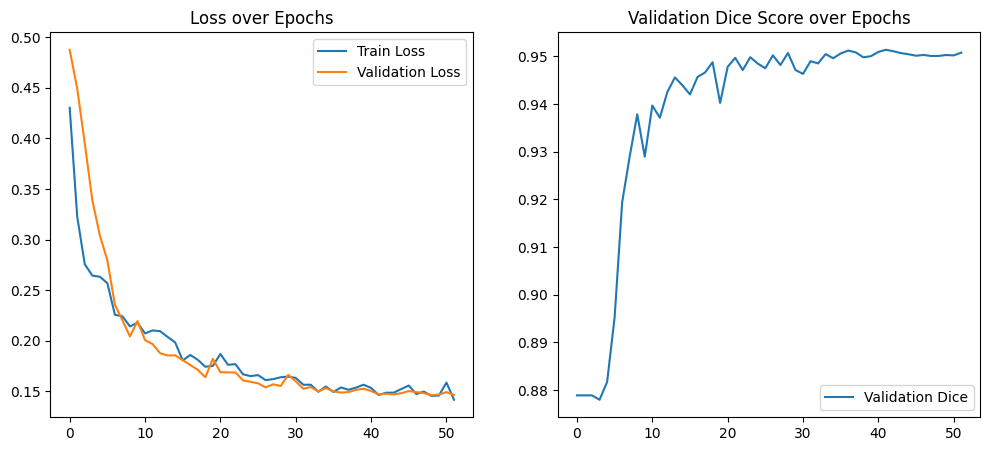


--- Visualizing Predictions on Validation Set ---


/tmp/ipykernel_1120991/3895567284.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.MODEL_SAVE_PATH)) # 加载最佳模型


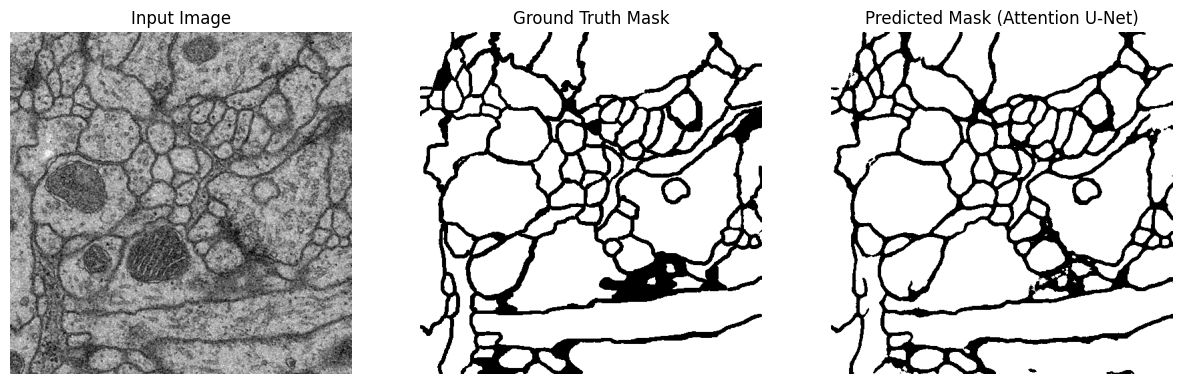

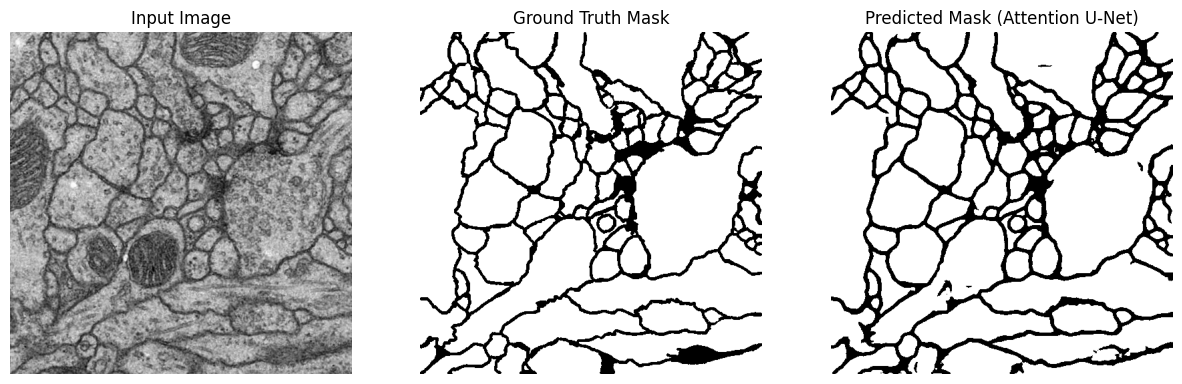

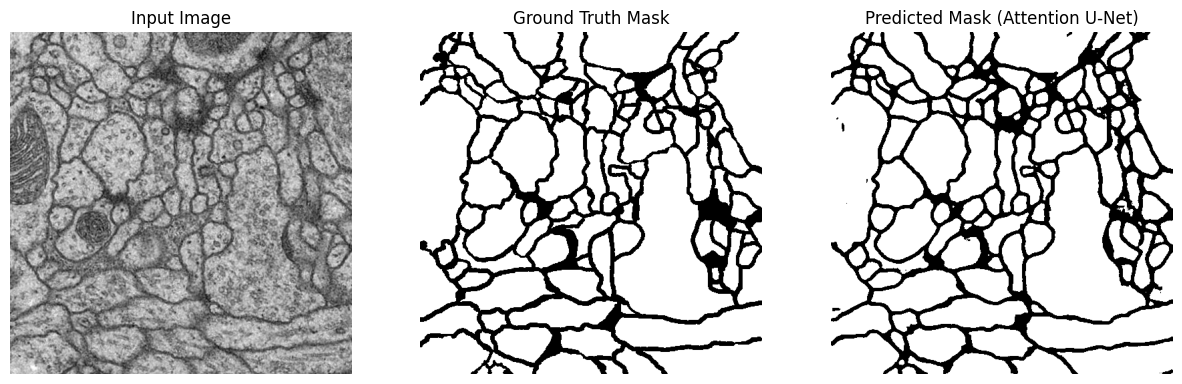

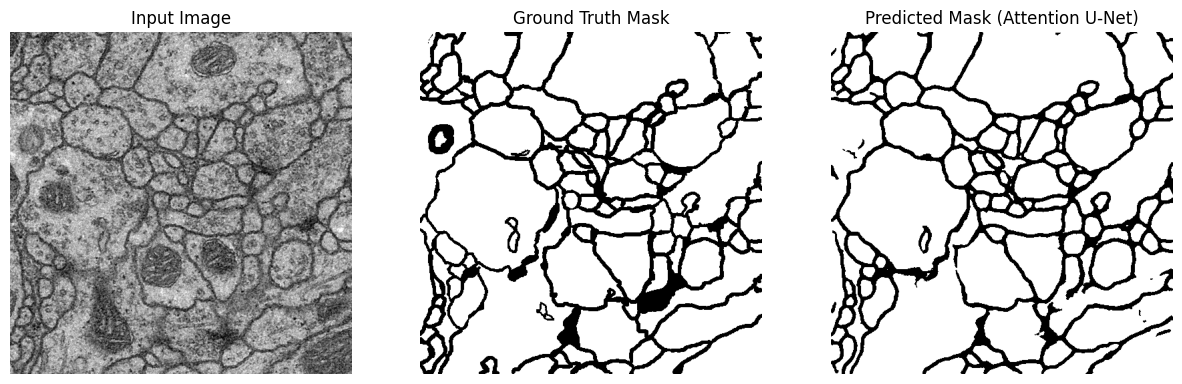

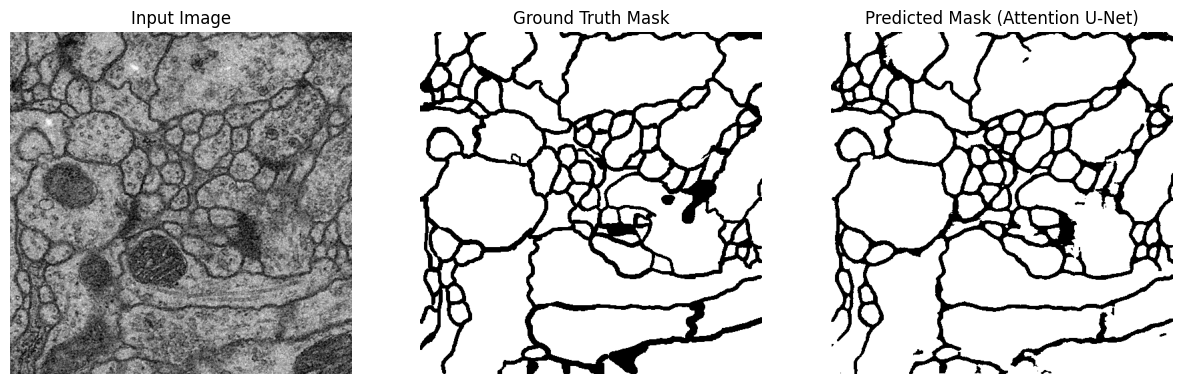

In [6]:
# ======================================================================
# 6. 主程序 (MAIN EXECUTION)
# ======================================================================
def main():
    # --- 加载数据 ---
    try:
        train_images = load_multipage_tiff(config.TRAIN_IMG_PATH)
        train_labels = load_multipage_tiff(config.TRAIN_LBL_PATH)
    except FileNotFoundError as e:
        print(e)
        return

    # --- 划分数据集 ---
    indices = list(range(len(train_images)))
    random.shuffle(indices)
    split_point = int(np.floor(config.VALIDATION_SPLIT * len(train_images)))
    val_indices, train_indices = indices[:split_point], indices[split_point:]

    train_dataset = ISBI_Dataset(train_images[train_indices], train_labels[train_indices], augment=True)
    val_dataset = ISBI_Dataset(train_images[val_indices], train_labels[val_indices], augment=False)
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    print(f"Data loaded: {len(train_dataset)} training samples, {len(val_dataset)} validation samples.")

    # --- 初始化模型、损失、优化器 ---
    model = AttentionUNet(n_channels=config.N_CHANNELS, n_classes=config.N_CLASSES).to(config.DEVICE)
    criterion = CombinedLoss().to(config.DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
    # 学习率调度器：当验证Dice系数不再提升时，降低学习率
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.1)

    # --- 训练循环与早停 ---
    best_val_dice = -1
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'val_dice': []}

    print("\n--- Starting Training with Attention U-Net ---")
    start_time = time.time()
    for epoch in range(config.NUM_EPOCHS):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, config.DEVICE)
        val_loss, val_dice = evaluate(model, val_loader, criterion, config.DEVICE)
        
        print(f"Epoch {epoch+1}/{config.NUM_EPOCHS} | Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)

        scheduler.step(val_dice) # 更新学习率

        # --- 保存最佳模型 ---
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
            print(f"  -> New best model saved with Dice: {best_val_dice:.4f}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        # --- 检查早停 ---
        if epochs_no_improve >= config.EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            break
    
    end_time = time.time()
    print(f"\nTraining finished in {(end_time - start_time)/60:.2f} minutes.")
    print(f"Best validation Dice score: {best_val_dice:.4f}")

    # --- 绘制训练历史 ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title("Loss over Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['val_dice'], label='Validation Dice')
    plt.title("Validation Dice Score over Epochs")
    plt.legend()
    plt.show()

    # --- 可视化预测结果 ---
    visualize_predictions(model, val_dataset, config)

def visualize_predictions(model, dataset, config):
    print("\n--- Visualizing Predictions on Validation Set ---")
    model.load_state_dict(torch.load(config.MODEL_SAVE_PATH)) # 加载最佳模型
    model.eval()
    
    num_visualize = min(5, len(dataset))
    for i in range(num_visualize):
        image, mask = dataset[i]
        image_gpu = image.unsqueeze(0).to(config.DEVICE)

        with torch.no_grad():
            output = model(image_gpu)
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(image.squeeze().numpy(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask.numpy(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask (Attention U-Net)")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')
        
        plt.show()

if __name__ == '__main__':
    main()